## Introduction
This jupyter notebook aims to explain the different evaluation metrics used in the [DCASE 2021 Task 4](http://dcase.community/challenge2021/task-sound-event-detection-and-separation-in-domestic-environments). 

The functions, files and predictions used in this jupyter notebook are the ones used in the baseline code. 


## Polyphonic and monophonic sound event detection

The task of sound event detection could be evaluated in different ways and there is not a generally accepted metric  for evaluating the system. 
 
In general, the evaluation of the system is performed by comparing the system output (the detections) with the reference available for the test data (the ground-truth). Usually, the comparison between the detections and the ground-truth is done in fixed length intervals, known as **segment-based metrics** or at event-instance level, also knows as **event-based metrics**. 
- ***Segment-based metrics***: comparing system output and reference in short time segments, where the lenght of the time interval can be chosen based on the desired resolution needed for the application.
- ***Event-based metrics***: comparing system output and reference event by event. The tolerance between two events can be chosen depending on the desired resolution, usually choosing a collar value depending on the lenght of the shortest and longest event. 

The statistics can be aggregated in different ways: 
- ***Instance-based averaging***: each individual decision has equal weight. This average is also knows as micro-averaging. 
- ***Class-based averaging***: every class has equal weight. This average is also knows as macro-averaging. 

For more information regarding the metrics for polyphonic evaluation please refer to [[1]](#References). 

## Intersection-based metrics

Each measure focuses on a different aspect of the system and it is not easy to raise a single clear conclusion about the performance of the system. In fact, using a single measure leads to an incomplete analysis of the system.
One solution could be to use a number of different metrics, in order to provide views of multiple aspects. 
It should be necessary to agree on a performance criterion when multiple systems are compared between each other.

Moreover, the following issues are ignored when using the aforementioned metrics:
- **Dependency on the operating point**: using different decision thresholds under the same metric for the same system may lead to different rankings. 
- **Definition of sound events**: event-based metrics are based on collars, the use of which emphasize the start and end times of sound events, while these times can be subjective among human labelers. Consequently, the evaluation criterion choosen should allow interpretation of the temporal structure of both the ground truth and the detection timings.
- **Prior probabilities, false-positives and cross-triggers in multi-class systems**: cross-triggers (CTs) are the subset of false positives which match another labelled class of the multi-class system. Distinguishing the behavior of CTs from the FPs can provide insight into data biases, particularly for sound classes which are acoustically similar. Indeed, if the amount of data required for reliable evaluation of the TPs for a particular target classes is incompatible with field priors, multi-class evaluation datasets may become biased. 

With the aim to overcome the limits mentionated above, [[2]](#References)
introduces the ***intersection criterion*** approach, driving to a new more robust definition of the TPs and FPs, and cross-triggers (CTs) in the context of polyphonic SED. The novel method considers the amount of overlap between the ground truth and the detections of the system.
In this way, both merged detections and interrupted detection can be supported, the evaluation is invariant to the time scale of the event durations, and its properties provide the flexibility needed to handle subjective labeling and to avoid event duration biases. 
The minimum amount of overlap required to validate the detections against the annotations is parameterized by three intersection ratios: the ***Detection Tolerance Criterion (DTC)***, ***the Ground Truth intersection Criterion (GTC)*** and the ***Cross-Trigger Tolerance Criterion (CTTC)***.

The figure below shows the differences between event-based, segment-based and intersection-based metrics. 
<img src="img/Metrics.png" alt="metrics computation" style="width: 75%;"/>

As seen in the figure, using different metrics results in different results. Depending on the application and the different cases, could make more sense to use one metric over another, or to use more than one metric simultaneously. 

## Polyphonic Sound Detection Score (PSDS)

Furthermore, the definition of the intersection criteria leads to new definitions of event-based ROC curve called **Polyphonic Sound Detection ROC (PSD-ROC) curve** and **Polyphonic Sound Detection Score (PSDS)**.

Depending on the values of the three intersection ratios (Detection Tolerance Criterion (DTC), the Ground Truth intersection Criterion (GTC) and the Cross-Trigger Tolerance Criterion (CTTC)), PSDS can be adjusted to have a similar level of constraints to segment-based or event-based evaluations and it can provide the advantages of both approaches, defining one or more scenarios according to the constraints and characteristics needed for each application. 

PSDS is global across a set of operating points, rather than depending on a single operating point chosen a priori for each submitted system as implied by the F1-score. Therefore PSDS prevents from erroneous conclusion that a system performs better at sound event detection than another one where, instead, the difference relies on a different choice of system sensitivity tuning.

More information regarding PSDS metrics and on how it works can bee found at this Jupyter Notebook [[4]](#References). 

More information regarding the ratios and PSDS can be found at [[2]](#References) and [[3]](#References). 

## Hands-on

### Event-based and segment-based metrics
Let's see in practice how to calculate the different metrics, the differences between them, and how to define different scenarios using PSDS and the relative results.

We will use the predictions from the baseline, which are saved inside the folder `meta`. 

First, let's import all the modules needed to run the code, and let's define the functions needed to calculate the metrics. The functions used in this jupyter notebook are the same functions used in the baseline.

In [1]:
import os
import sed_eval 
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings("ignore")

We will first define all the functions that we will need to evaluate the system and calculate the metrics. 

The function `get_event_list_current_file` gets the list of events present in a given filename and return it as dataframe.

In [2]:
def get_event_list_current_file(df, fname):
    """
    Get list of events for a given filename
    Args:
        df: pd.DataFrame, the dataframe to search on
        fname: the filename to extract the value from the dataframe
    Returns:
         list of events (dictionaries) for the given filename
    """
    event_file = df[df["filename"] == fname]
    if len(event_file) == 1:
        if pd.isna(event_file["event_label"].iloc[0]):
            event_list_for_current_file = [{"filename": fname}]
        else:
            event_list_for_current_file = event_file.to_dict("records")
    else:
        event_list_for_current_file = event_file.to_dict("records")

    return event_list_for_current_file

The function `event_based_evaluation_df` calculates the event-based metric. It receives the reference and estimated dataframe as input. 

In [3]:
def event_based_evaluation_df(
    reference, estimated, t_collar=0.200, percentage_of_length=0.2
):
    """ Calculate EventBasedMetric given a reference and estimated dataframe

    Args:
        reference: pd.DataFrame containing "filename" "onset" "offset" and "event_label" columns which describe the
            reference events
        estimated: pd.DataFrame containing "filename" "onset" "offset" and "event_label" columns which describe the
            estimated events to be compared with reference
        t_collar: float, in seconds, the number of time allowed on onsets and offsets
        percentage_of_length: float, between 0 and 1, the percentage of length of the file allowed on the offset
    Returns:
         sed_eval.sound_event.EventBasedMetrics with the scores
    """
    evaluated_files = reference["filename"].unique()

    classes = []
    classes.extend(reference.event_label.dropna().unique())
    classes.extend(estimated.event_label.dropna().unique())
    classes = list(set(classes))

    event_based_metric = sed_eval.sound_event.EventBasedMetrics(
        event_label_list=classes,
        t_collar=t_collar,
        percentage_of_length=percentage_of_length,
        empty_system_output_handling="zero_score",
    )

    for fname in evaluated_files:
        reference_event_list_for_current_file = get_event_list_current_file(
            reference, fname
        )
        estimated_event_list_for_current_file = get_event_list_current_file(
            estimated, fname
        )

        event_based_metric.evaluate(
            reference_event_list=reference_event_list_for_current_file,
            estimated_event_list=estimated_event_list_for_current_file,
        )

    return event_based_metric

The function `segment_based_evaluation_df` calculates the segment-based metric. It receives the reference and estimated dataframe as input.

In [4]:
def segment_based_evaluation_df(reference, estimated, time_resolution=1.0):
    """ Calculate SegmentBasedMetrics given a reference and estimated dataframe

        Args:
            reference: pd.DataFrame containing "filename" "onset" "offset" and "event_label" columns which describe the
                reference events
            estimated: pd.DataFrame containing "filename" "onset" "offset" and "event_label" columns which describe the
                estimated events to be compared with reference
            time_resolution: float, the time resolution of the segment based metric
        Returns:
             sed_eval.sound_event.SegmentBasedMetrics with the scores
        """
    evaluated_files = reference["filename"].unique()

    classes = []
    classes.extend(reference.event_label.dropna().unique())
    classes.extend(estimated.event_label.dropna().unique())
    classes = list(set(classes))

    segment_based_metric = sed_eval.sound_event.SegmentBasedMetrics(
        event_label_list=classes, time_resolution=time_resolution
    )

    for fname in evaluated_files:
        reference_event_list_for_current_file = get_event_list_current_file(
            reference, fname
        )
        estimated_event_list_for_current_file = get_event_list_current_file(
            estimated, fname
        )

        segment_based_metric.evaluate(
            reference_event_list=reference_event_list_for_current_file,
            estimated_event_list=estimated_event_list_for_current_file,
        )

    return segment_based_metric

The function `compute_sed_eval_metric` computes the event-based and segment-based metrics. The default parameters of the task are used for the calculation of the metrics.

In [5]:
def compute_sed_eval_metrics(predictions, groundtruth):
    """ Compute sed_eval metrics event based and segment based with default parameters used in the task.
    Args:
        predictions: pd.DataFrame, predictions dataframe
        groundtruth: pd.DataFrame, groundtruth dataframe
    Returns:
        tuple, (sed_eval.sound_event.EventBasedMetrics, sed_eval.sound_event.SegmentBasedMetrics)
    """
    metric_event = event_based_evaluation_df(
        groundtruth, predictions, t_collar=0.200, percentage_of_length=0.2
    )
    metric_segment = segment_based_evaluation_df(
        groundtruth, predictions, time_resolution=1.0
    )

    return metric_event, metric_segment

All the functions that will be needed to calculate the metrics have been defined.

Now, let's read the ground-truth labels and save them in the `gt` dataframe. 

In [6]:
# read ground truth labels and save them in the gt dataframe
ground_truth_file="meta/validation.tsv"
gt = pd.read_csv(ground_truth_file, sep="\t")
gt.head() # will print only the 5 rows of the gt dataframe

,filename,onset,offset,event_label
0,Y00pbt6aJV8Y_350.000_360.000.wav,0.00,9.971,Vacuum_cleaner
1,Y00pK0GMmE9s_70.000_80.000.wav,0.00,10.000,Vacuum_cleaner
2,Y02sD1KJeoGA_50.000_60.000.wav,0.00,10.000,Frying
3,Y0bjUq9XMMmQ_30.000_40.000.wav,0.00,10.000,Frying
4,Y0cH_NlhhMAs_30.000_40.000.wav,1.71,6.005,Cat


The ground truth labels have been saved in the `gt` dataframe. 

We will focus only on the metrics related to the **student** system. If you want to consider the metrics for the teacher as well, you can follow the same process replacing the student predictions with the teacher predictions, which you will find in the `meta` folder. 

We will first calculate the **event-based F1-score** and the **segmentation-based F1-score**, so at this stage, we will only need the predictions considering a threshold of 0.5. 

Let's read the ground-truth labels and save them in the `preds_s` dataframe.

In [7]:
# read ground truth labels and save them in the preds_s dataframe
predictions_student_file="meta/metrics_test/student/predictions0.5.csv"
preds_s = pd.read_csv(predictions_student_file, index_col=0)
preds_s.head() # will print only the first 5 rows of the preds_s dataframe

,event_label,onset,offset,filename
0,Vacuum_cleaner,0.000,9.984,Y00pbt6aJV8Y_350.000_360.000.wav
1,Vacuum_cleaner,0.000,9.984,Y00pK0GMmE9s_70.000_80.000.wav
2,Frying,0.000,9.984,Y02sD1KJeoGA_50.000_60.000.wav
3,Running_water,2.112,3.584,Y0bjUq9XMMmQ_30.000_40.000.wav
4,Running_water,3.968,9.984,Y0bjUq9XMMmQ_30.000_40.000.wav


Now we can compute the event-based and the segment-based metrics using the functions thta we declared before and we can save the metrics in the folder specified as `save_dir`. The files `event_f1.txt` and `segment_f1.txt` report more information regarding the metrics. Check them out. 

Let's calculate the event-based and segment-based metrics.

In [8]:
# calculate event-based and segment-based metrics
save_dir="meta/metrics_test/student"

event_metrics_s, segment_metrics_s = compute_sed_eval_metrics(preds_s, gt)

with open(os.path.join(save_dir, "event_f1.txt"), "w") as f:
    f.write(str(event_metrics_s))

with open(os.path.join(save_dir, "segment_f1.txt"), "w") as f:
    f.write(str(segment_metrics_s))

#### Event-based metrics

In [9]:
print("Event-based metric class-wise average metrics (macro average) {:.2f}%".format(event_metrics_s.results()["class_wise_average"]["f_measure"]["f_measure"] * 100))
print("Event-based metric overall metrics (micro average) {:.2f}%".format(event_metrics_s.results()["overall"]["f_measure"]["f_measure"] * 100))

Event-based metric class-wise average metrics (macro average) 39.83%
Event-based metric overall metrics (micro average) 40.92%


#### Segment-based metrics

In [10]:
print("Segment-based metric class-wise average metrics (macro average) {:.2f}%".format(segment_metrics_s.results()["class_wise_average"]["f_measure"]["f_measure"] * 100)) 
print("Segment-based metric overall metrics (micro average) {:.2f}%".format(segment_metrics_s.results()["overall"]["f_measure"]["f_measure"] * 100))

Segment-based metric class-wise average metrics (macro average) 69.35%
Segment-based metric overall metrics (micro average) 75.47%


As we would expect and as we can see from the results, the segment-based metrics are more lenient compared to the event-based metrics, resulting in higher performances. As we discussed before, the segment-based metric compares system output and reference in short time segments while the event-based metric compares system output and reference event by event giving less tolerance to the system. 

### Intersection-based metrics

Let's now analyse the **intersection-based metric**. In order to do this, we will need to import some modules more and to define the relative functions. Also in this case, the functions are the same used in the baseline code.

In [11]:
import psds_eval
from psds_eval import PSDSEval, plot_per_class_psd_roc

The function `compute_per_intersection_macro_f1` computes F1-score per intersection, using the default values.

In [12]:
def compute_per_intersection_macro_f1(
    preds,
    gt,
    durations,
    dtc_threshold=0.5,
    gtc_threshold=0.5,
    cttc_threshold=0.3,
):
    """ Compute F1-score per intersection, using the default
    Args:
        prediction_dfs: dict, a dictionary with thresholds keys and predictions dataframe
        ground_truth_file: pd.DataFrame, the groundtruth dataframe
        durations_file: pd.DataFrame, the duration dataframe
        dtc_threshold: float, the parameter used in PSDSEval, percentage of tolerance for groundtruth intersection
            with predictions
        gtc_threshold: float, the parameter used in PSDSEval percentage of tolerance for predictions intersection
            with groundtruth
        gtc_threshold: float, the parameter used in PSDSEval to know the percentage needed to count FP as cross-trigger

    Returns:

    """

    psds = PSDSEval(
        ground_truth=gt,
        metadata=durations,
        dtc_threshold=dtc_threshold,
        gtc_threshold=gtc_threshold,
        cttc_threshold=cttc_threshold,
    ) 
    
    psds_macro_f1 = []
    
    if not preds.empty:
        threshold_f1, _ = psds.compute_macro_f_score(preds)
    else:
        threshold_f1 = 0
    if np.isnan(threshold_f1):
        threshold_f1 = 0.0

    psds_macro_f1.append(threshold_f1)
    
    psds_macro_f1 = np.mean(psds_macro_f1)
    return psds_macro_f1

In order to properly calculate the metrics based on the intersection of the events, it is necessary to know the durations of them, so they will be retrieved and saved in the `durations` dataframe. 
After that, the function `compute_per_intersection_macro_f1` will be called to calculate the metric. 

In [13]:
# retrieve durations event metadata
durations = pd.read_csv("meta/validation_durations.tsv", sep="\t")

# intersection-based metric
psds_macro_f1_s = compute_per_intersection_macro_f1(preds_s, gt, durations)
print("Intersection-based F-score student {:.2f}%".format(psds_macro_f1_s * 100))

Intersection-based F-score student 63.74%


### Summary  

The following table summarized the different F-score metrics analyzed so far for the student model of the baseline and depending on the event matching criterion. 

#### <center>Student metrics<center>
| Event-based (macro average)| Event-based (micro average) | Segment-based (macro average)| Segment-based (micro average)| Intersection |
| :-: | :-: | :-: | :-: | :-: |
| 39.83% | 40.92% | 69.35% | 75.47% | 63.74%

## PSDS and the two different scenario of the baseline 

As already discussed, depending on the values of the three intersection ratios (DTC, GTC Tolerance Criterion CTTC), PSDS can be adjusted to have different level of constraints and it can provide the advantages of defining one or more scenarios according to the constraints and characteristics needed for each application. 

For a better evaluation of the system and to better understand the behavior of each submission, two different scenarios as been proposed for the DCASE 2021 Task 4, each of which emphasize different systems properties.

#### Scenario 1

The system needs to react fast upon an event detection (e.g. to trigger an alarm, adapt home automation system...). The localization of the sound event is then really important. The PSDS parameters reflecting these needs are:

- Detection Tolerance criterion (DTC): 0.7
- Ground Truth intersection criterion (GTC): 0.7
- Cost of instability across class (αST): 1
- Cost of CTs on user experience (αCT): 0
- Maximum False Positive rate (e_max): 100


This is the strictest scenario between the two, imposing high DTC and GTC. These values guarantee constraints in time in the intersection between reference and detection in order for the detection to be considered true positive. It does not allow to have instability between classes and the cross-triggers are not considered in this scenario.

#### Scenario 2

The system must avoid confusing between classes but the reaction time is less crucial than in the first scenario. The PSDS parameters reflecting these needs are:

- Detection Tolerance criterion (DTC): 0.1
- Ground Truth intersection criterion (GTC): 0.1
- Cost of instability across class (αST): 1
- Cross-Trigger Tolerance criterion (cttc): 0.3
- Cost of CTs on user experience (αCT): 0.5
- Maximum False Positive rate (e_max): 100

This system is more permissive compared to the previous one, having lower DTC and GTC values. In this case, there is still the need of having an intersection between reference and detection but the system is less severe in terms of time and duration of intersection between the two. Also, in this case, instability between classes is not allowed but the cross-triggers are considered less critical, so the system permits to take them into account, recognizing that the system is able to detect an event.

## Scenario 1 and Scenario 2 in practice

In [14]:
import glob
import os.path as osp
from psds_eval import plot_psd_roc
import matplotlib.pyplot as plt

Let's define the functions that will be needed to define the different scenarios. The functions are the same as the baseline, with some small modifications. In particular, in the following function, since the prediction files are directly retrieved, the dataframe already contains all the columns needed to calculate the PSDS, so the two lines which would add the index column to the dataframe (as the baseline code does) are commented in the following cell. 
Please, see issue https://github.com/audioanalytic/psds_eval/issues/3 for more information. 

In the following function, we also return `psds_eval` (which is not returned is the baseline code) since would be necessary to show the impact of the different scenario for each class. 

The third difference is that there is no need to save the predictions so we have removed this part from the function. 

Also in this case, we will consider only the **student** metrics. If you want to consider the metrics for the teacher as well, you can follow the same process replacing the student predictions with the teacher predictions, which you will find in the `meta` folder as well. 

The function `compute_psds_from_operating_points` computes the PSDS metric from operating points. Different values of input parameters could be specified in order to defined different scenarios. 

In [15]:
def compute_psds_from_operating_points(
    prediction_dfs,
    gt,
    durations,
    dtc_threshold=0.5,
    gtc_threshold=0.5,
    cttc_threshold=0.3,
    alpha_ct=0,
    alpha_st=0,
    max_efpr=100,
    save_dir=None,
):

    psds_eval = PSDSEval(
        ground_truth=gt,
        metadata=durations,
        dtc_threshold=dtc_threshold,
        gtc_threshold=gtc_threshold,
        cttc_threshold=cttc_threshold,
    )
    
    

    for i, k in enumerate(prediction_dfs.keys()):
        k = round(k, 2)
        det = prediction_dfs[k]
        # see issue https://github.com/audioanalytic/psds_eval/issues/3
        #det["index"] = range(1, len(det) + 1)
        #det = det.set_index("index")
        psds_eval.add_operating_point(
            det, info={"name": f"Op {i + 1:02d}", "threshold": k}
        )

    psds_score = psds_eval.psds(alpha_ct=alpha_ct, alpha_st=alpha_st, max_efpr=max_efpr)

    return psds_score, psds_eval

Let's collect all the predictions for each operating point and save them in `test_psds_buffer_student`, which is
a dictionary of dataframe, one for each operating point.  

In [16]:
# taking all the predictions for each operating point and save them in a dictionary of dataframee
test_n_thresholds = 50

test_thresholds = np.arange(
    1 / (test_n_thresholds * 2), 1, 1 / test_n_thresholds
)

test_psds_buffer_student = {k: pd.DataFrame() for k in test_thresholds}


for i, tsv in enumerate(glob.glob(osp.join("meta/metrics_test/student/predictions_operating_points/*.tsv"))):
    threshold = float("0." + tsv.split(".")[-2])
    test_psds_buffer_student[threshold] = pd.read_csv(tsv, sep="\t")

Let's calculate the PSDS metrics for the two scenarios defined for the DCASE 2021 Task 4.

In [17]:
# psds scenario 1
psds_scenario1_s, psds_eval_scen1 = compute_psds_from_operating_points(
    test_psds_buffer_student, 
    gt, 
    durations, 
    dtc_threshold=0.7,
    gtc_threshold=0.7,
    alpha_ct=0,
    alpha_st=1
)

# psds scenario 2
psds_scenario2_s, psds_eval_scen2 = compute_psds_from_operating_points(
            test_psds_buffer_student, 
            gt, 
            durations,
            dtc_threshold=0.1,
            gtc_threshold=0.1,
            cttc_threshold=0.3,
            alpha_ct=0.5,
            alpha_st=1
        )

print("Psds scenario 1 student: {:.3f}".format(psds_scenario1_s.value))
print("Psds scenario 2 student: {:.3f}".format(psds_scenario2_s.value))

Psds scenario 1 student: 0.334
Psds scenario 2 student: 0.533


Scenario 1


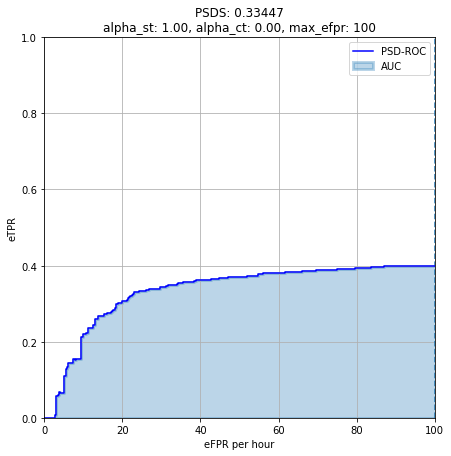

Scenario 2


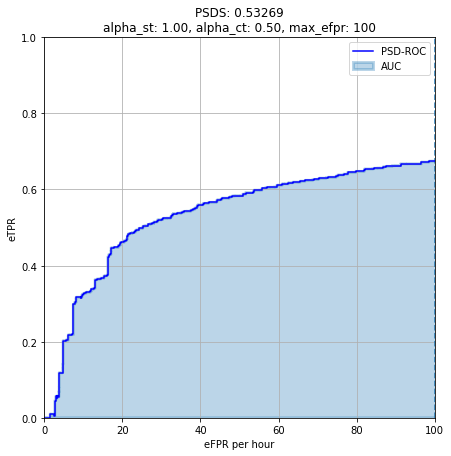

In [18]:
print("Scenario 1")
plot_psd_roc(psds_scenario1_s)


print("Scenario 2")
plot_psd_roc(psds_scenario2_s)

As we can see from the plots, scenario 2 is more permissive interms of segmentation and leads to higher PSDS than. The impact of CTC is not really obvious here. Additionaly, the impact of the relaxed constraints on the segmentation may not be affecting each class equivalently. 

### PSDS per class for Scenario 1

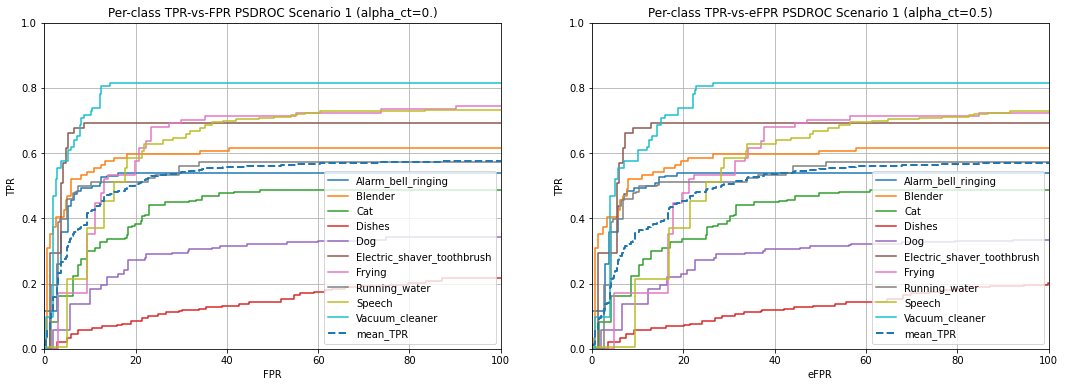

In [19]:
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

tpr_vs_fpr, _, _ = psds_eval_scen1.psd_roc_curves(alpha_ct=0.)
plot_per_class_psd_roc(tpr_vs_fpr, psds_eval_scen1.class_names, axes=axes[0], title="Per-class TPR-vs-FPR PSDROC Scenario 1 (alpha_ct=0.)", xlabel="FPR", xlim=100)

_, _, tpr_vs_efpr = psds_eval_scen1.psd_roc_curves(alpha_ct=0.5)
plot_per_class_psd_roc(tpr_vs_efpr, psds_eval_scen1.class_names, axes=axes[1], title="Per-class TPR-vs-eFPR PSDROC Scenario 1 (alpha_ct=0.5)", xlabel="eFPR", xlim=100)

### PSDS per class for Scenario 2

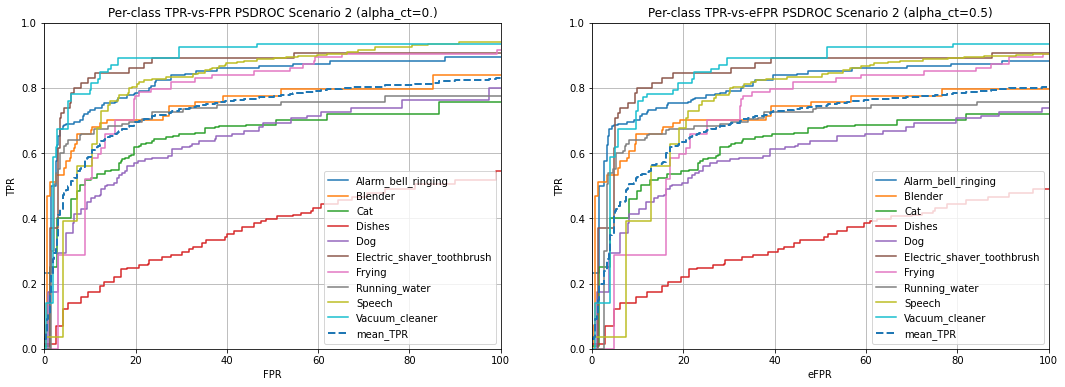

In [20]:
fig, axes = plt.subplots(1, 2, figsize=(18, 6))


tpr_vs_fpr, _, _ = psds_eval_scen2.psd_roc_curves(alpha_ct=0.)
plot_per_class_psd_roc(tpr_vs_fpr, psds_eval_scen2.class_names, axes=axes[0], title="Per-class TPR-vs-FPR PSDROC Scenario 2 (alpha_ct=0.)", xlabel="FPR", xlim=100)

_, _, tpr_vs_efpr = psds_eval_scen2.psd_roc_curves(alpha_ct=0.5)
plot_per_class_psd_roc(tpr_vs_efpr, psds_eval_scen2.class_names, axes=axes[1], title="Per-class TPR-vs-eFPR PSDROC Scenario 2 (alpha_ct=0.5)", xlabel="eFPR", xlim=100)

As already seen from the PSDS scores, the performances are shifting from scenario 1 to scenario 2, with an overall increase for all the classes. 

In particular, the short event classes are the most affected, as it could be observed from the graphs. In fact, for classes such as `vacuul_cleaner` and `blender`, the shift is not so important compared to classes such as `dishes`, `cat` and `frying`, can see their performance increased drastically between scenario 1 and scenario 2. 
    Usually, short events are between the most difficult events to be detected, due to their shortness. As observed here and in [[3]](#References), the bad performance usually observed on short event can also be related to segmentation constraint that are too tight while computing the metric. 

## REFERENCES

[1]: Mesaros, Annamaria, Toni Heittola, and Tuomas Virtanen. "Metrics for polyphonic sound event detection." Applied Sciences 6.6 (2016): 162. 
URL: https://www.mdpi.com/2076-3417/6/6/162

[2]: Bilen, Çağdaş, et al. "A framework for the robust evaluation of sound event detection." ICASSP 2020-2020 IEEE International Conference on Acoustics, Speech and Signal Processing (ICASSP). IEEE, 2020. URL: https://arxiv.org/pdf/1910.08440.pdf

[3]: Ferroni, Giacomo, et al. "Improving sound event detection metrics: insights from dcase 2020." arXiv preprint arXiv:2010.13648 (2020). URL: https://arxiv.org/pdf/2010.13648.pdf

[4]: URL: https://github.com/audioanalytic/psds_eval/blob/master/jupyter/psds.ipynb
